In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Data Mining/Data/'

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining/Data/df2022_WiClass.csv')
Features = ['HPVADVC4', 'HPVADSHT', 'SHINGLE2', 'COVIDVA1', 'COVACGET', 'COVIDNU1', 'COVIDINT', 'COVIDFS1', 'COVIDSE1', 'COPDCOGH',
            'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVTRT3', 'CSRVDOC1', 'CSRVSUM',
            'CSRVRTRN', 'CSRVINST', 'CSRVINSR', 'CSRVDEIN', 'CSRVCLIN', 'CSRVPAIN', 'CSRVCTL2', 'PSATEST1', 'PSATIME1', 'PCPSARS2',
            'PSASUGST', 'PCSTALK1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'CDDISCUS', 'CAREGIV1', 'CRGVREL4',
            'CRGVLNG1', 'CRGVHRS1', 'CRGVPRB3', 'CRGVALZD', 'CRGVPER1', 'CRGVHOU1', 'CRGVEXPT', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS',
            'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'ACEADSAF', 'ACEADNED',
            'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS', 'Class']
df = df_full[Features]

In [ ]:
df.head()

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2, pvalue, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
#@title Function for binary variable exploration
def explore_binary(df, feature, include_refused=False):
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(df[feature]==7)} not sure, {np.sum(df[feature]==9)} refused')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")
  else:
    subdf = df[[feature, 'Class']]
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})
    if not include_refused:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No']
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)| (subdf[feature] == 7)| (subdf[feature] == 9)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No', 7: 'Not Sure', 9: 'Refused'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No', 'Not Sure', 'Refused']
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

There are 11208 missing values, 101 not sure, 104 refused


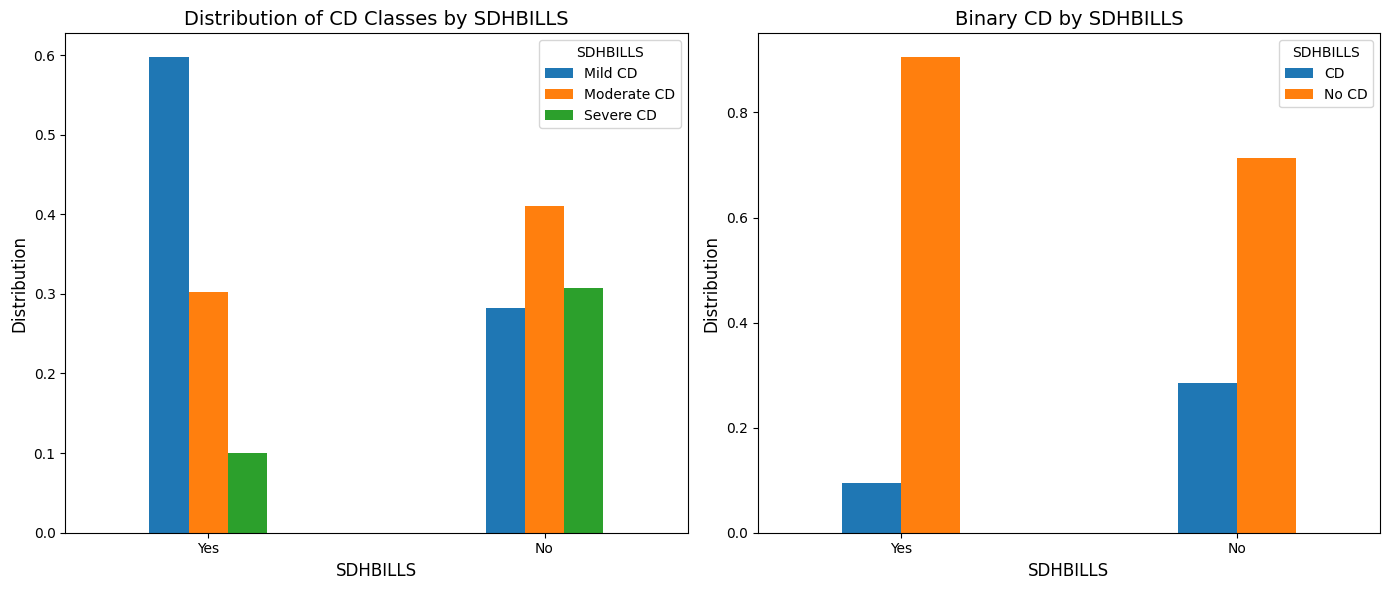

Cramers V for multi-class classification is: 0.26628603253641947
Cramers V for binary classification is: 0.14481301990397233


In [ ]:
explore_binary(df, 'SDHBILLS', include_refused=False)

In [ ]:
#@title Function for categorical variable exploration
# mapping = {1:'Always', 2:"Usually",..., 7:"Not Sure", 9:"Refused"}
def explore_cat(df, feature, mapping, include_refused=False):
  subdf = df[[feature, 'Class']]
  subdf[feature] = subdf[feature].replace(mapping)
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(subdf[feature]=="Not Sure")} not sure values, {np.sum(subdf[feature]=="Refused")} refused values')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset = [feature], inplace=True)
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    if not include_refused:
      subdf = subdf[~((subdf[feature] == 'Not Sure') | (subdf[feature] == 'Refused'))]

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())[:-2]
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())
      frequencies.reindex(idx_order)
      frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

There are 21543 missing values, 481 not sure values, 651 refused values


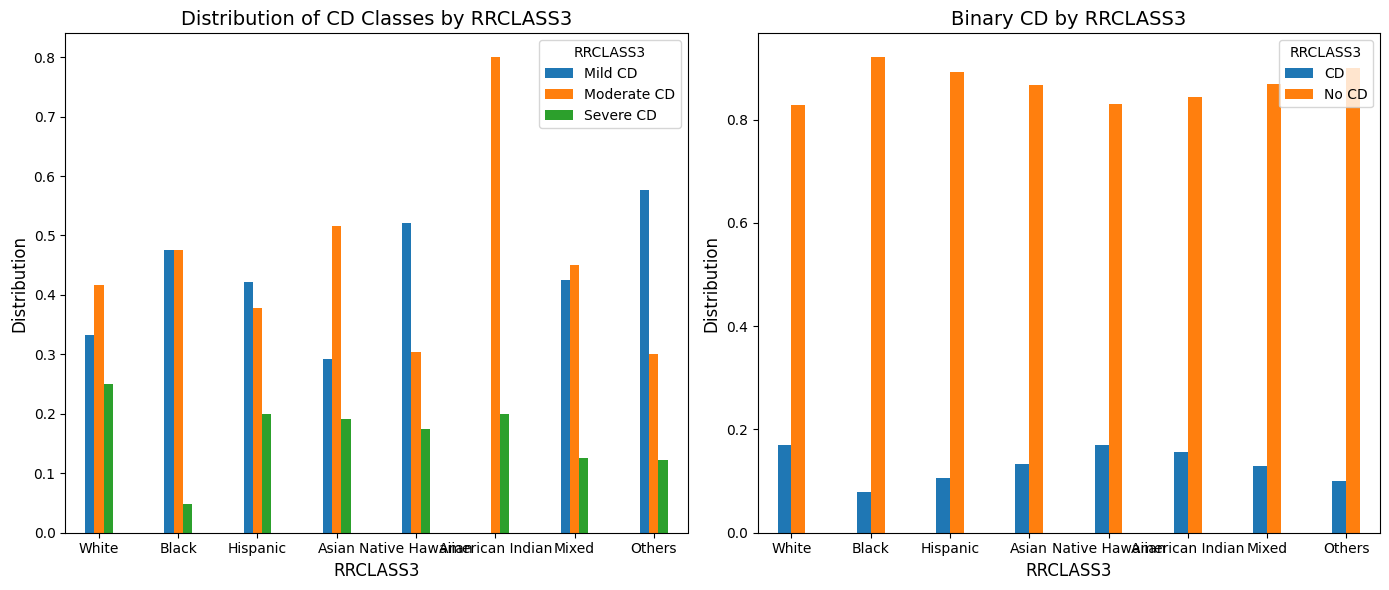

Cramers V for multi-class classification is: 0.09278408934266809
Cramers V for binary classification is: 0.024560654428750855


In [ ]:
# mapping = {1:"Gay", 2: "Straight", 3: "Bi", 4:"Others", 7: "Not Sure", 9: "Refused"}
mapping = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 7: 'Mixed', 8:'Others',
            77: "Not Sure", 99: "Refused"}
# mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
feature = 'RRCLASS3'

explore_cat(df_full, feature, mapping, include_refused=False)

In [ ]:
#@title Function for continuous variable exploration
def explore_cts(df, feature, none=88, not_sure=77, refused=99):
  subdf = df[[feature, 'Class']]
  print(f'There are {subdf[feature].isna().sum()} missing values, {np.sum(subdf[feature]==not_sure)} not sure values, {np.sum(subdf[feature]==refused)} refused values')

  if np.sum(~subdf[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset=[feature], inplace=True)
    subdf = subdf[~((subdf[feature]==not_sure) | (subdf[feature]==refused))]
    subdf[feature] = subdf[feature].replace(none, 0)

    desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
    desired_order2 = ['CD', 'No CD']

    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    sns.kdeplot(data=subdf[(subdf['Class']!='No CD')], x=feature, hue='Class', hue_order=desired_order,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Distribution of {feature} within different CD classes', fontsize=14)
    axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')

    sns.kdeplot(data=subdf, x=feature, hue='Binary Classification', hue_order=desired_order2,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Distribution of {feature} with and without CD', fontsize=14)
    axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')

    plt.tight_layout()
    plt.show()

    groups = [group[feature] for name, group in subdf[(subdf['Class']!='No CD')].groupby('Class')]
    f_statistic, p_value = f_oneway(*groups)

    print("p-value for multi-class classification is:", p_value)

    groups2 = [group[feature] for name, group in subdf.groupby('Binary Classification')]
    f_statistic, p_value2 = f_oneway(*groups2)

    print("p-value for binary classification:", p_value2)



There are 32441 missing values, 0 not sure values, 225 refused values


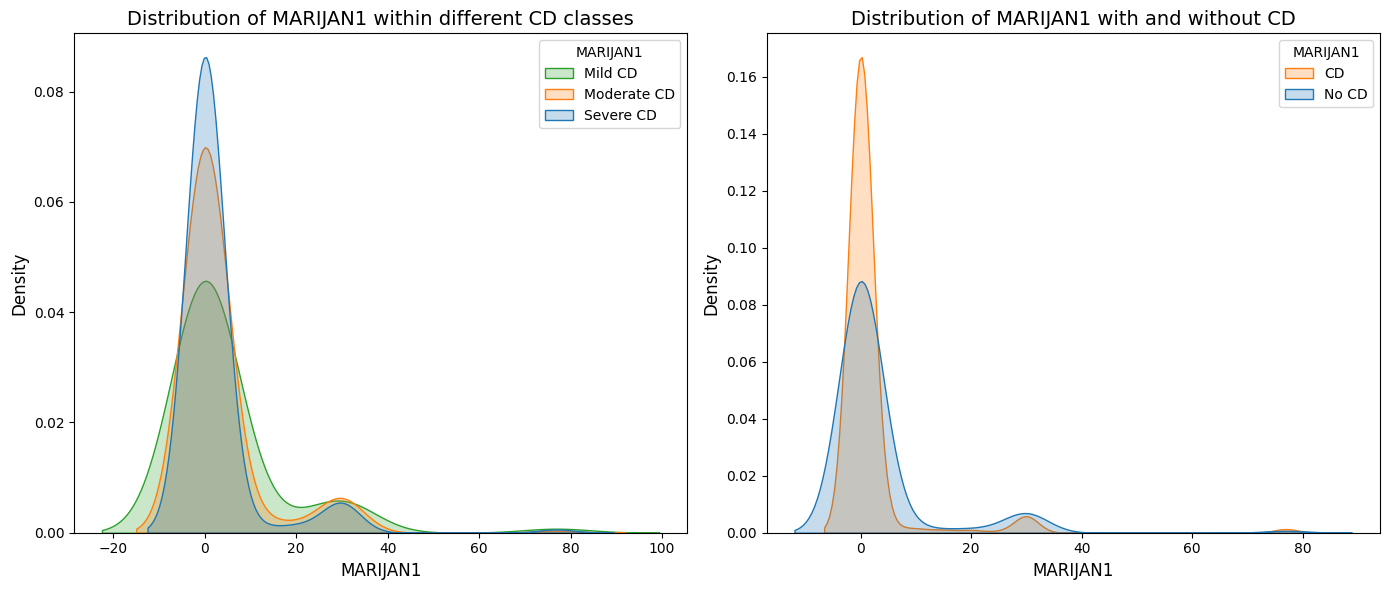

p-value for multi-class classification is: 0.0006882650826244949
p-value for binary classification: 2.975320202468408e-14


In [ ]:
feature = 'MARIJAN1';

explore_cts(df_full, feature, none=88, not_sure=98, refused=99)